# Adaptive Quantum Neural Network (QNN)-based Quantum Deep Learning (QDL) for Classifier

Created by Muhamad Akrom m.akrom@dsn.dinus.ac.id

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

from sklearn.datasets import load_iris
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, roc_curve, auc

from IPython.display import clear_output

from qiskit import Aer
from qiskit_algorithms.utils import algorithm_globals
from qiskit.circuit import QuantumCircuit, ParameterVector
from qiskit.utils import QuantumInstance
from qiskit.opflow import PauliSumOp
from qiskit.opflow import StateFn
from qiskit_machine_learning.neural_networks import EstimatorQNN
from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier
from qiskit.algorithms.optimizers import COBYLA, ADAM, L_BFGS_B, GradientDescent, QNSPSA, AQGD, GradientDescentState, SLSQP

/var/folders/nd/s6snn9l53zg5sthh_ttcvdpr0000gn/T/ipykernel_2258/606942226.py:17: DeprecationWarning: The ``qiskit.opflow`` module is deprecated as of qiskit-terra 0.24.0. It will be removed in Qiskit 1.0. For code migration guidelines, visit https://qisk.it/opflow_migration.
  from qiskit.opflow import PauliSumOp
/var/folders/nd/s6snn9l53zg5sthh_ttcvdpr0000gn/T/ipykernel_2258/606942226.py:21: DeprecationWarning: ``qiskit.algorithms`` has been migrated to an independent package: https://github.com/qiskit-community/qiskit-algorithms. The ``qiskit.algorithms`` import path is deprecated as of qiskit-terra 0.25.0 and will be removed in Qiskit 1.0. Please run ``pip install qiskit_algorithms`` and use ``import qiskit_algorithms`` instead.
  from qiskit.algorithms.optimizers import COBYLA, ADAM, L_BFGS_B, GradientDescent, QNSPSA, AQGD, GradientDescentState, SLSQP


### 1. Load Dataset (Iris)

In [2]:
data_iris = load_iris()
x = data_iris.data
y = data_iris.target

# Buat binary class
indexes = np.array([i for (i, s) in enumerate(y) if (s == 0 or s == 1)])
x = x[indexes]
y = 2 * y[indexes] - 1

### 2. Pre-processing

In [3]:
# Scaler

x = MinMaxScaler().fit_transform(x)

In [4]:
# Split

algorithm_globals.random_seed = 123
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=algorithm_globals.random_seed)

In [5]:
# Ofv

objective_func_vals = []
def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

### 3. Adaptive QNN-based QDL Model

/var/folders/nd/s6snn9l53zg5sthh_ttcvdpr0000gn/T/ipykernel_2258/2790007804.py:3: DeprecationWarning: The 'qiskit.Aer' entry point is deprecated and will be removed in Qiskit 1.0. You should use 'qiskit_aer.Aer' directly instead.
  simulator        = Aer.get_backend('qasm_simulator')
/var/folders/nd/s6snn9l53zg5sthh_ttcvdpr0000gn/T/ipykernel_2258/2790007804.py:4: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed in the Qiskit 1.0 release. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(simulator)
/var/folders/nd/s6snn9l53zg5sthh_ttcvdpr0000gn/T/ipykernel_2258/2790007804.py:28: DeprecationWarning: The class ``qiskit.opflow.state_fns.operator_state_fn.OperatorStateFn`` is deprecated as of qiskit-terra 0.24.0. It will be removed in the Qiskit 1.0 release. For code migration guidelines, visit https://qisk.it/opflow_migration.
  qnn_expectation  = 

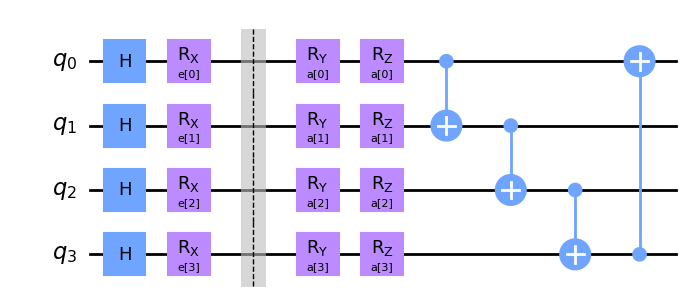

In [6]:
# Parameter
num_qubits       = x.shape[1]
simulator        = Aer.get_backend('qasm_simulator')
quantum_instance = QuantumInstance(simulator)
optimizer        = COBYLA(maxiter=100)                             # Dapat dioptimisasi
param_encoding   = ParameterVector('e', num_qubits)                
param_ansatz     = ParameterVector('a', num_qubits)                
observable       = PauliSumOp.from_list([("XYZI", 1.0)])           # Dapat divariasi

qc = QuantumCircuit(num_qubits)

# Encoding
for i in range (num_qubits):
    qc.h(i)
    qc.rx(param_encoding[i], i)

qc.barrier()

# Ansatz
for i in range (num_qubits):
    qc.ry(param_ansatz[i], i)
    qc.rz(param_ansatz[i], i)
for i in range(num_qubits-1): 
    qc.cx(i, i+1)
qc.cx(3, 0)

# QNN classifier
qnn_expectation  = StateFn(observable, is_measurement=True) @ StateFn(qc)
estimator_qnn    = EstimatorQNN(
    circuit=qc, 
    observables=observable, 
    input_params=param_encoding, 
    weight_params=param_ansatz
)
qnn = NeuralNetworkClassifier(
    estimator_qnn, optimizer=optimizer, loss='squared_error', callback=callback_graph
)

# Plot sirkuit
qc.draw(output='mpl', style="clifford")

### 4. Training

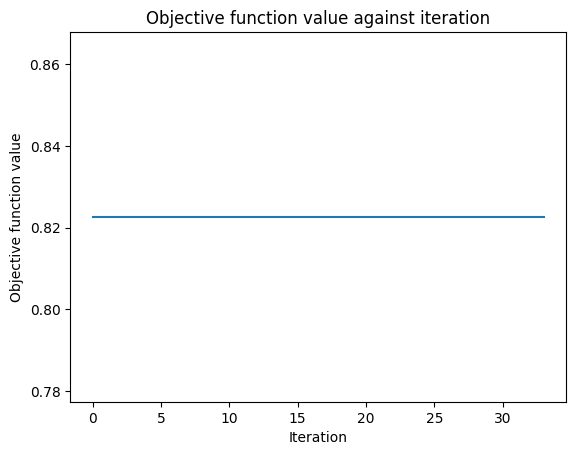

Training time: 4 seconds


In [8]:
start   = time.time()

qnn.fit(x_train, y_train)

elapsed = time.time() - start

print(f"Training time: {round(elapsed)} seconds")

### 5. Evaluation

In [9]:
y_pred_tr = qnn.predict(x_train)
y_pred_ts = qnn.predict(x_test)

print('TRAIN:')
report_tr      = classification_report(y_train, y_pred_tr)
print(report_tr)

print('TEST:')
report_ts      = classification_report(y_test, y_pred_ts)
print(report_ts)

TRAIN:
              precision    recall  f1-score   support

          -1       1.00      0.02      0.05        41
           1       0.49      1.00      0.66        39

    accuracy                           0.50        80
   macro avg       0.75      0.51      0.35        80
weighted avg       0.75      0.50      0.35        80

TEST:
              precision    recall  f1-score   support

          -1       0.00      0.00      0.00         9
           1       0.55      1.00      0.71        11

    accuracy                           0.55        20
   macro avg       0.28      0.50      0.35        20
weighted avg       0.30      0.55      0.39        20



/Users/muhammadreesarosyid/tensorflow-test/env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/muhammadreesarosyid/tensorflow-test/env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/muhammadreesarosyid/tensorflow-test/env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(av

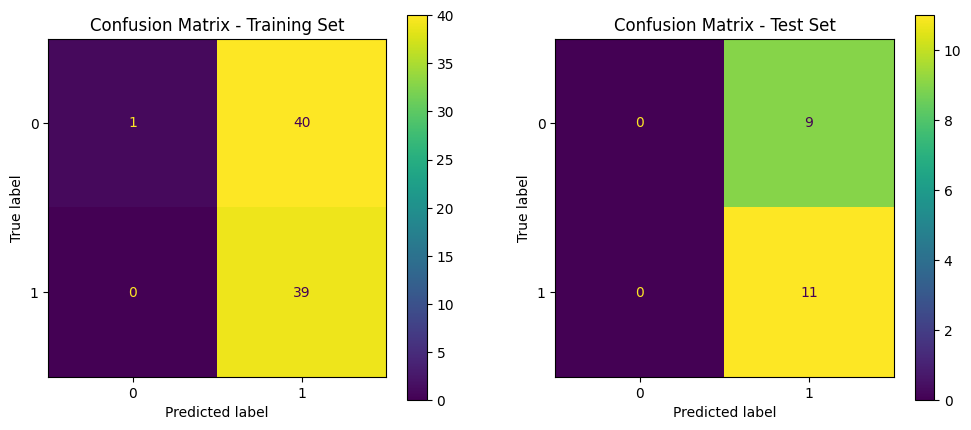

In [10]:
cm_tr   = confusion_matrix(y_train, y_pred_tr)
disp_tr = ConfusionMatrixDisplay(confusion_matrix=cm_tr)
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
disp_tr.plot(ax=ax[0])
ax[0].set_title('Confusion Matrix - Training Set')

cm_ts   = confusion_matrix(y_test, y_pred_ts)
disp_ts = ConfusionMatrixDisplay(confusion_matrix=cm_ts)
disp_ts.plot(ax=ax[1])
ax[1].set_title('Confusion Matrix - Test Set')

plt.show()

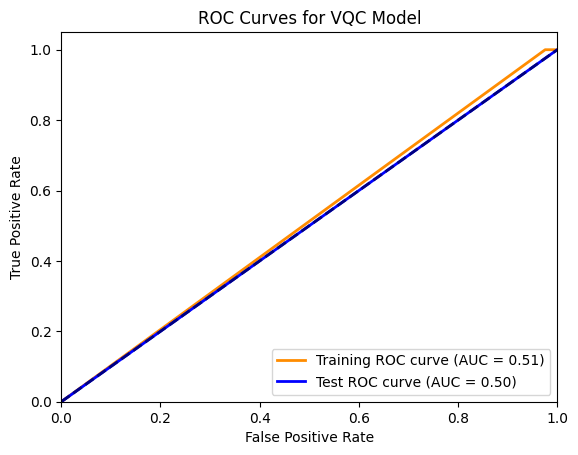

In [11]:
fpr_tr, tpr_tr, _ = roc_curve(y_train, y_pred_tr)
roc_auc_tr        = auc(fpr_tr, tpr_tr)
fpr_ts, tpr_ts, _ = roc_curve(y_test, y_pred_ts)
roc_auc_ts        = auc(fpr_ts, tpr_ts)

plt.figure()
plt.plot(fpr_tr, tpr_tr, color='darkorange', lw=2, label=f'Training ROC curve (AUC = {roc_auc_tr:0.2f})')
plt.plot(fpr_ts, tpr_ts, color='blue', lw=2, label=f'Test ROC curve (AUC = {roc_auc_ts:0.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for VQC Model')
plt.legend(loc="lower right")
plt.show()